## Import relevant libraries and add certain paths


In [5]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from int_act_pred.data import read_training, read_test
from int_act_pred.models import train_model, test_model

import sys
sys.path.insert(1, '../old_code/moa/')
from utils import ring_substructs
from search import all_hits
from search import count_hits
from search import significance
from search import sig_subs
from search import ring_search
from search import functional_search
from search import ring_hits
from search import functional_hits

In [6]:
def ftp_to_dataset (path):
    f = open (path, "r")
    lines = (f.read().split ('\n'))[:-1]
    return np.array([np.array([int(c) for c in s]) for s in lines])

## Get ring structures from training data, create feature vectors

In [7]:
training_data = read_training("../data/training_set.csv")
training_data["id"] = [i for i in range (len(training_data))]
#gets all unique rings from training data set
rings = (ring_substructs(training_data))
print (rings)

          id                                           smiles  \
0    RING000                                       c1cCCCcc-1   
1    RING001                                         c1cNCCC1   
2    RING002                                         C1=CNCC1   
3    RING003                                        C1CCCNCC1   
4    RING004                                          c1nCCO1   
..       ...                                              ...   
256  RING256                                         c1cSccN1   
257  RING257                                         C1COCCO1   
258  RING258                                         c1cSCCC1   
259  RING259  C1=CC=CC=CC=CCCOCCCCCCCCCCCCCCCCCCCCCC=CC=CC=C1   
260  RING260                                      C1CCOCCCOC1   

                                               mol  
0    <rdkit.Chem.rdchem.Mol object at 0x1029f4490>  
1    <rdkit.Chem.rdchem.Mol object at 0x1029f4a30>  
2    <rdkit.Chem.rdchem.Mol object at 0x102a22990>  
3    <r

In [8]:
#extract all unique rings structure and unique functional groups and hit table.
#hit table contains the rings and functional groups present in each training molecule
hit_table, ring_substructs, func_substructs = all_hits(training_data, rings)

#converts hit_table to a binary array. each row corresponds to a molecules. rows are binary 
#vectors. one corresponds to presence of ring or functional group
HT = hit_table.values
HT_train = HT[:,1:]
y_train = training_data.activity.astype('int')

In [9]:
ring_substructs

id                                           smiles  \
0    RING000                                       c1cCCCcc-1   
1    RING001                                         c1cNCCC1   
2    RING002                                         C1=CNCC1   
3    RING003                                        C1CCCNCC1   
4    RING004                                          c1nCCO1   
..       ...                                              ...   
256  RING256                                         c1cSccN1   
257  RING257                                         C1COCCO1   
258  RING258                                         c1cSCCC1   
259  RING259  C1=CC=CC=CC=CCCOCCCCCCCCCCCCCCCCCCCCCC=CC=CC=C1   
260  RING260                                      C1CCOCCCOC1   

                                               mol  
0    <rdkit.Chem.rdchem.Mol object at 0x1029f4490>  
1    <rdkit.Chem.rdchem.Mol object at 0x1029f4a30>  
2    <rdkit.Chem.rdchem.Mol object at 0x102a22990>  
3    <rdkit.Chem.rdchem.Mol object at 0x102a22bc0>  
4    <rdkit.Chem.rdchem.Mol object at 0x102a229e0>  
..                                             ...  
256  <rdkit.Chem.rdchem.Mol object at 0x102a31210>  
257  <rdkit.Chem.rdchem.Mol object at 0x102a31170>  
258  <rdkit.Chem.rdchem.Mol object at 0x102a313f0>  
259  <rdkit.Chem.rdchem.Mol object at 0x102a31350>  
260  <rdkit.Chem.rdchem.Mol object at 0x102a31490>  

[261 rows x 3 columns]

In [10]:
func_substructs

id              name  \
0   FUNC000          hydroxyl   
1   FUNC001          carboxyl   
2   FUNC002          carbonyl   
3   FUNC003             oxime   
4   FUNC004             ester   
5   FUNC005             ether   
6   FUNC006             amine   
7   FUNC007             imine   
8   FUNC008           nitrile   
9   FUNC009         hydrazine   
10  FUNC010         hydrazone   
11  FUNC011           nitroso   
12  FUNC012     hydroxylamine   
13  FUNC013             nitro   
14  FUNC014               azo   
15  FUNC015             azide   
16  FUNC016             amide   
17  FUNC017           amidine   
18  FUNC018         guanidine   
19  FUNC019             imide   
20  FUNC020        isocyanate   
21  FUNC021    isothiocyanate   
22  FUNC022       thiocyanate   
23  FUNC023        haloalkane   
24  FUNC024         thioether   
25  FUNC025             thiol   
26  FUNC026      thiocarbonyl   
27  FUNC027           sulfone   
28  FUNC028       sulfonamide   
29  FUNC029         carbamide   
30  FUNC030   phosphoric_acid   
31  FUNC031  phosphoric_ester   

                                               smarts  \
0                                      [[#6]-[O]-[H]]   
1                                [[#6]-C(=O)-[O]-[H]]   
2         [[#6]-[CX3](=O)-[#6], [CX3](-[H])(=O)-[#6]]   
3                   [[X]-[CX3](-[H])=[NX2]-[OX2]-[H]]   
4                       [[#6]-[CX3](=O)-[OX2H0]-[#6]]   
5                                 [[OD2](-[#6])-[#6]]   
6   [[X]-[N](-[H])-[H], [X]-[N](-[H])-[X], [X]-[N]...   
7                                    [[Nv3](=C)-[#6]]   
8                                       [[NX1]#[CX2]]   
9                                       [[NX3]-[NX3]]   
10                                        [C=N-[NX3]]   
11                                       [[#6]-[N]=O]   
12                          [[N](-O(-[H]))(-[X])-[C]]   
13                                [[C]-[N](-[O])=[O]]   
14                            [[#6]-N=N-[#6], [N+]#N]   
15         [[NX2-]-[NX2+]#[NX1], [NX2]=[NX2+]=[NX1-]]   
16                                      [[X]-C(=O)-N]   
17                                    [C(=N)(-N)-[X]]   
18                                  [C(=N)(-[N])-[N]]   
19                                    [N(-C(=O))-C=O]   
20                                        [[X]-N=C=O]   
21                                        [[X]-N=C=S]   
22                                        [[X]-S-C#N]   
23                     [C-[Cl], C-[Br], C-[I], C-[F]]   
24                                   [[SX2](-[#6])-C]   
25                                      [[X]-[S]-[H]]   
26                                          [C=[SX1]]   
27                            [S(=O)(=O)(-[#6])-[#6]]   
28                                 [N-S(=O)(=O)-[#6]]   
29                                      [C(=O)(-N)-N]   
30                   [P([OX1])([OX2H])([OX2H])[OX2H]]   
31          [P(=[OX1])(-[OX2]-[X])(-[O]-[X])-[O]-[X]]   

                                          func       type  
0           <function hydroxyl at 0x11b45c280>     oxygen  
1           <function carboxyl at 0x11b45c430>     oxygen  
2           <function carbonyl at 0x11b647b80>     oxygen  
3              <function oxime at 0x11b647c10>     oxygen  
4              <function ester at 0x11b647ca0>     oxygen  
5              <function ether at 0x11b647d30>     oxygen  
6              <function amine at 0x11b647dc0>   nitrogen  
7              <function imine at 0x11b647e50>   nitrogen  
8            <function nitrile at 0x11b647ee0>   nitrogen  
9          <function hydrazine at 0x11b647f70>   nitrogen  
10         <function hydrazone at 0x11b64a040>   nitrogen  
11           <function nitroso at 0x11b64a0d0>   nitrogen  
12     <function hydroxylamine at 0x11b64a160>   nitrogen  
13             <function nitro at 0x11b64a1f0>   nitrogen  
14               <function azo at 0x11b64a280>   nitrogen  
15             <function azide at 0x11b64a310>   nitrogen  
16             <f

In [11]:
HT_train.shape

(2335, 293)

## Get testing data, create feature vectors from test data 

In [12]:
#repeat of process above, except we do it for training data

In [13]:
testing_data = read_training("../data/test_set_filtered.csv")
identification = list(range(0,162));
testing_data['id'] = identification


In [14]:
hit_table, ring_substructs, func_substructs  = all_hits(testing_data, rings)
HT = hit_table.values
HT_test = HT[:,1:]
y_test = testing_data.activity.astype('int')

## Train Extra Trees Model

In [15]:
from sklearn import tree
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier

In [16]:

#final_model = LogisticRegression( max_iter = 5000, C = 5, class_weight = 'balanced')
#final_model = tree.DecisionTreeClassifier(class_weight = 'balanced')
#final_model = GaussianNB()
#final_model = MultinomialNB()
#final_model = BernoulliNB()
#final_model = LogisticRegression( C = .1, penalty = 'l1', solver = 'liblinear',max_iter = 2000,class_weight = 'balanced')
#final_model = tree.DecisionTreeClassifier(class_weight = 'balanced')
final_model = sklearn.ensemble.ExtraTreesClassifier(n_estimators=100, random_state=0)
#final_model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
#final_model = clf = svm.SVC(class_weight = "balanced")
#final_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
#final_model = RandomForestClassifier(max_depth=12, random_state=0)

In [17]:
scores = cross_val_score(final_model, HT_train, y_train, cv=5, scoring = "balanced_accuracy")

In [18]:
scores

array([0.73758465, 0.74548533, 0.74209932, 0.621614  , 0.58220467])

In [19]:
final_model.fit(HT_train,y_train)

ExtraTreesClassifier(random_state=0)

In [20]:
np.sum(final_model.predict(HT_test) == y_test)

130

In [21]:
r = np.where(y_test == 1)[0]
final_model.predict(HT_test)[r]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0])

## True positive rate and False positive rate

In [22]:
totPos = np.sum(final_model.predict(HT_test))
totPosTrue = np.sum(final_model.predict(HT_test) * y_test)
TPR = totPosTrue*1.0/totPos
print("TPR is ", TPR)

TPR is  0.7333333333333333


In [23]:
totNeg = np.sum(1-final_model.predict(HT_test))
totNegTrue = np.sum((1-final_model.predict(HT_test)) * (y_test))
FCR = totNegTrue*1.0/totNeg
#FNR = 1- FCR
print("FNR is ", FCR)

FNR is  0.17094017094017094


In [24]:
print("Recall is ", np.sum(final_model.predict(HT_test)[r])/r.shape[0])

Recall is  0.6226415094339622


In [25]:
print("Accuracy is", np.sum(final_model.predict(HT_test) == y_test)/y_test.shape[0])

Accuracy is 0.8024691358024691


## ROC curve

In [26]:
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
#get ROC curve of extra trees model
temp = final_model.predict_proba(HT_test)[:,1] 

In [28]:
final_model.predict(HT_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_test+1, temp, pos_label=2)

In [30]:
#AUC of logistic regression
metrics.auc(fpr, tpr)

0.8651549247014021

In [31]:
#Get ROC curve of Stokes et al.
td = pd.read_csv("../data/test_set_filtered.csv")

In [32]:
td.Pred_Score

0      0.967200
1      0.957037
2      0.952527
3      0.942160
4      0.931109
         ...   
157    0.000222
158    0.000212
159    0.000193
160    0.000185
161    0.000182
Name: Pred_Score, Length: 162, dtype: float64

In [33]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test+1, td.Pred_Score, pos_label=2)

In [34]:
#AUC of extra trees
metrics.auc(fpr1, tpr1)

0.8880041544054007

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


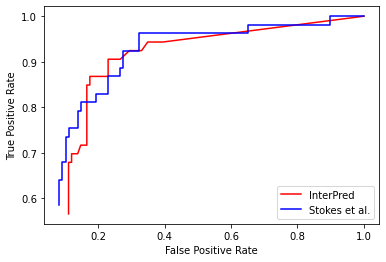

In [35]:
plt.figure()
plt.plot(fpr[9:],tpr[9:], "r-", label = "InterPred")
plt.plot(fpr1[15:],tpr1[15:],"b-", label='Stokes et al.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('ROC_CURVE.eps', format='eps')

## Now let's do mode of action

## To extract important ring structures, first train logistic regression model

In [36]:
cvec = [ 0.01 , .05, .1 , .15 , .2]

In [37]:
for k in range(0,5):
    final_model = LogisticRegression( C = cvec[k], penalty = 'l1', solver = 'liblinear',max_iter = 2000,class_weight = 'balanced')
    final_model.fit(HT_train,y_train)
    scores = cross_val_score(final_model, HT_train, y_train, cv=20, scoring = "balanced_accuracy")
    print(str(int(np.average(scores)*100))+ " percent" )# + "--- number of ")
    #print( np.sum(final_model.coef_ > 0))


68 percent
73 percent
76 percent
77 percent
76 percent


In [38]:
#Since for .1, .15, and .2, the validation score is essnetially the same and for .1 
# we get the the sparsest coefficients, we stick with .1 regularization

In [39]:
final_model = LogisticRegression( C = .1, penalty = 'l1', solver = 'liblinear',max_iter = 2000,class_weight = 'balanced')
final_model.fit(HT_train,y_train)
    

LogisticRegression(C=0.1, class_weight='balanced', max_iter=2000, penalty='l1',
                   solver='liblinear')

In [40]:
temp = final_model.predict_proba(HT_test)[:,1] 

In [41]:
fpr, tpr, thresholds = metrics.roc_curve(y_test+1, temp, pos_label=2)

In [42]:
metrics.auc(fpr, tpr)

0.8262939241821015

In [43]:
import pandas as pd

In [47]:
# get mechanism of action reported in drug repurposing hub
moa_test_df = pd.read_csv("test_moa.csv")

In [48]:
moa_test = moa_test_df.values

In [49]:
indicator = np.zeros((4495))

In [50]:
#check which molecules in drug repurposing hub are reported
for k in range(0,4495):
    if(type(moa_test[k,7]) == str):
        indicator[k] = 1

In [51]:
testing_data = pd.read_csv("../data/test_set_filtered.csv")

In [52]:
testing_data = testing_data.values

In [53]:
h = np.zeros((99))
ind = np.zeros((99))

In [54]:
#find mechanism of action of each molecule in training data that has activity against ecoli
for k in range(0,99):
    t = np.where(moa_test[:,0] == testing_data[k,0] )[0]
    if(t.shape[0] >0):
        h[k] = t
        ind[k] = 90
    
    

In [55]:
mode = moa_test[h.astype('int'),7]

In [56]:
loc = np.where(ind == 90)[0]

In [57]:
mode_look = mode

In [58]:
HT_test_look = HT_test[loc,:]

In [59]:
np.sort(final_model.coef_[0,:])[::-1][0:15]

array([2.42287818, 1.67718367, 1.01236049, 0.98693537, 0.97255176,
       0.823     , 0.7902292 , 0.77659973, 0.52843939, 0.48202117,
       0.33270944, 0.31408538, 0.15716858, 0.14717494, 0.13606795])

In [60]:
np.argsort(final_model.coef_[0,:])[::-1][0:15]

array([106, 244, 182, 254,  54, 267, 274, 251,  88, 178, 245, 271, 162,
       261, 218])

In [61]:
yt = np.argsort(final_model.coef_[0,:])[::-1][0:15]

In [62]:
## now cluster data, keep the top 5 features (the 5 features that the highest logistic regression coefficient)

In [63]:
temporary = HT_test_look[:,yt[0:5]]


In [64]:
from sklearn.cluster import KMeans

In [65]:
kmeans = KMeans(n_clusters=9, random_state=0).fit(temporary)

In [66]:
kmeans.labels_

array([0, 5, 0, 0, 3, 0, 5, 3, 0, 0, 3, 6, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0,
       1, 0, 0, 0, 0, 3, 0, 0, 1, 1, 0, 3, 0, 8, 1, 6, 1, 0, 1, 3, 7, 1,
       0, 7, 0, 4, 7, 0, 0, 4, 4, 0, 1, 1, 4, 1, 1, 3, 3, 1, 0, 5, 1, 3,
       3, 1, 1, 0, 4, 1, 6, 5, 3, 4, 1, 3, 3, 1, 1, 1, 2, 3, 1, 4, 1, 1,
       1, 1, 1, 1, 1, 4, 1, 1, 2, 2, 5], dtype=int32)

In [67]:
## Look at reported mechanism (from drug repurposing hub) of action of clusters

In [68]:
mode_look[np.where(kmeans.labels_==0)[0]] 

array(['bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',


In [69]:
mode_look[np.where(kmeans.labels_==3)[0]] 

array(['bacterial DNA gyrase inhibitor', 'bacterial DNA gyrase inhibitor',
       'bacterial DNA gyrase inhibitor', 'bacterial DNA gyrase inhibitor',
       'bacterial DNA gyrase inhibitor', 'bacterial DNA gyrase inhibitor',
       'topoisomerase inhibitor', 'HIV integrase inhibitor',
       'HIV integrase inhibitor', 'AKT inhibitor', 'HDAC inhibitor', nan,
       'topoisomerase inhibitor', 'ATP synthase inhibitor',
       'p38 MAPK inhibitor'], dtype=object)

In [70]:
mode_look[np.where(kmeans.labels_==4)[0]]

array(['bacterial 50S ribosomal subunit inhibitor',
       'bacterial 30S ribosomal subunit inhibitor',
       'retinoid receptor agonist', 'protein synthesis inhibitor',
       'bacterial 30S ribosomal subunit inhibitor',
       'bacterial 30S ribosomal subunit inhibitor',
       'bacterial 30S ribosomal subunit inhibitor',
       'topoisomerase inhibitor'], dtype=object)

In [71]:
mode_look[np.where(kmeans.labels_==6)[0]]

array(['bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor',
       'bacterial cell wall synthesis inhibitor'], dtype=object)

In [72]:
mode_look[np.where(kmeans.labels_==7)[0]]

array(['bacterial permeability inducer', 'bacterial permeability inducer',
       'bacterial permeability inducer'], dtype=object)